# Proje: Beyin Tümörü MRI Görüntü Sınıflandırma

**Amaç:** Bu proje, beyin MR görüntüleri üzerinden tümör türlerini sınıflandırmayı hedefler. Görüntüler, glioma, meningioma, pituitary ve notumor olmak üzere dört kategoriye ayrılacaktır.

**Yaklaşım:** Bu bir görüntü sınıflandırma problemidir. Çözüm için, transfer öğrenme tekniğiyle önceden eğitilmiş bir ResNet50 modelini kullanacağız. Proje, veri ön işleme, veri artırma ve modelin eğitimini içeren aşamalardan oluşmaktadır.

# Adım 1: Gerekli Kütüphaneleri Import Etme, Sabit Değişkenleri Atama ve GPU'yu Test Etme

In [16]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
from keras.layers import BatchNormalization
import shutil

import cv2
import os
import io
import json

<h3> Sabitler ve Dosya Yolları </h3>
Metrikleri hızlıca değiştirmek için projeye eklenen sabitler ve dosya yolları

In [17]:
image_size = 128
BATCH_SIZE = 16
EPOCHS = 50

output_dir = 'ML-Models'
ModelName = 'ResNet50_best_tumor_classifier.h5'
train_data_base_path = '../BrainCancerClassification/BrainCancerClassification/Data/BrainTumorMRI/CleanedTraining'
test_data_base_path = '../BrainCancerClassification/BrainCancerClassification/Data/BrainTumorMRI/CleanedTesting'

logs_directory = 'Logs-of-Tumor-Resnet50'

if os.path.exists(logs_directory):
    shutil.rmtree(logs_directory)

#Dosya yoksa, oluştur
model_path = os.path.join(output_dir, ModelName)
os.makedirs(output_dir, exist_ok=True)

<h3> Ekran Kartı Testi ve Karma Hassasiyet Kurulumu(float16)</h3>

In [18]:
print("--- Setting up GPU memory ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print("--- GPU setup complete ---")

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

--- Setting up GPU memory ---
1 Physical GPUs, 1 Logical GPUs
--- GPU setup complete ---


# Adım 2: Görüntü Verilerinin Okunması ve Model İçin Hazırlanması
Bu adımda, daha önceden C# ile temizlenip klasörlere ayrılmış olan eğitim (Training) ve test (Testing) setlerindeki beyin MR görüntüleri okunur. Görüntüler, derin öğrenme modeline beslenmeden önce bir dizi ön işleme ve standardizasyon işleminden geçirilir. 


In [19]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # eğitim görselleri.
y_train  = [] # eğitim etiketleri.
x_test = [] # test görseleri.
y_test = [] # test etiketleri.

for label in labels:
    trainPath = os.path.join(train_data_base_path,label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) 
        image = cv2.bilateralFilter(image, 2, 50, 50) 
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) 
        image = cv2.resize(image, (image_size, image_size)) 
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join(test_data_base_path,label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

def normalize_in_chunks(data, chunk_size=1000):
    normalized_data = []
    for i in range(0, len(data), chunk_size):
        chunk = np.array(data[i:i+chunk_size], dtype=np.float32) / 255.0
        normalized_data.append(chunk)
    return np.vstack(normalized_data)

x_train = normalize_in_chunks(x_train)
x_test = normalize_in_chunks(x_test)
print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 1314.13it/s]


(5712, 128, 128, 3)
(1311, 128, 128, 3)


# Adım 3: Doğrulama Veri Setinin Ayrılması ve One Hot Encoding

In [20]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) 

print(x_val.shape)

(1143, 128, 128, 3)


# Adım 4: Veri Artırımı (Data Augmentation) Uygulanması

Bu adımda, modelin eğitim sürecinde daha sağlam ve genellenebilir olmasını sağlamak amacıyla, mevcut eğitim verilerine ImageDataGenerator kullanılarak veri artırımı (Data Augmentation) uygulanır.

In [21]:
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05, 
    height_shift_range=0.05,
    horizontal_flip=True,
    preprocessing_function=lambda x: x) 

datagen.fit(x_train)

# Adım 5: Özelleştirilmiş ResNet50 Modelinin Oluşturulması ve Derlenmesi

Bu adımda, görüntü sınıflandırma için önceden eğitilmiş ResNet50 modeli kullanılır ve transfer öğrenme amacıyla üst katmanı çıkarılır. Çıkarılan bu katman yerine, yeni bir sınıflandırma başlığı eklenir. Son olarak, model Adam optimizer ile derlenerek eğitime hazır hale getirilir.

In [22]:

net = ResNet50(
    weights='imagenet', 
     include_top=False, 
     input_shape=(image_size,image_size,3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = BatchNormalization()(model)  
model = Dropout(0.2)(model)  
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001 * (BATCH_SIZE / 8))
model.compile(optimizer=adam, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

# Adım 6: Model Eğitimi Sırasında Karmaşıklık Matrisi Oluşturma

Bu adımda, modelin eğitim performansı TensorBoard aracılığıyla görselleştirilmek üzere Karmaşıklık Matrisi (Confusion Matrix) oluşturulur. 

In [23]:
%load_ext tensorboard

class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

def log_confusion_matrix(epoch, logs):
    try:
        predictions = []
        batch_size = BATCH_SIZE
        
        for i in range(0, len(x_test), batch_size):
            batch = x_test[i:i+batch_size]
            with tf.device('/GPU:0'):
                batch_pred = model.predict(batch, verbose=0)
            predictions.extend(np.argmax(batch_pred, axis=1))
        
        predictions = np.array(predictions)
        cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
        figure = plot_confusion_matrix(cm, class_names=class_names)
        cm_image = plot_to_image(figure)
        
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
            
    except Exception as e:
        print(f"Error in confusion matrix logging at epoch {epoch}: {str(e)}")

<h3> TensorBoard Oluşturulması</h3>

In [24]:
logdir = os.path.join(logs_directory, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(logdir, exist_ok=True)

print(f"Directory '{logs_directory}' has been removed and a new one created at: {logdir}")

%tensorboard --logdir {logs_directory}

Directory 'Logs-of-Tumor-Resnet50' has been removed and a new one created at: Logs-of-Tumor-Resnet50\20250829-021242


# Adım 7: Modelin Eğitilmesi

Bu aşamada, modelin eğitimi için EarlyStopping, ReduceLROnPlateau ve ModelCheckpoint gibi geri çağırmalar (callbacks) tanımlanır. Bu geri çağırmalar, aşırı öğrenmeyi önlemek, öğrenme oranını ayarlamak ve en iyi modeli kaydetmek için kullanılır. Son olarak, model veri artırımı ile hazırlanan eğitim verileri kullanılarak model.fit() ile eğitilirken, bu süreç boyunca TensorBoard ile performansı izlenir.

In [25]:
#log yazmak için writer oluştur
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)

Checkpoint = ModelCheckpoint(filepath = model_path,monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES, RL, tensorboard, Checkpoint, LambdaCallback(on_epoch_end=log_confusion_matrix)]

steps_per_epoch = len(x_train) // BATCH_SIZE

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
285/285 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.8364
Epoch 1: val_loss improved from inf to 2.23256, saving model to ML-Models\ResNet50_best_tumor_classifier.h5
285/285 [==============================] - 54s 143ms/step - loss: 0.5084 - accuracy: 0.8364 - val_loss: 2.2326 - val_accuracy: 0.2336 - lr: 2.0000e-04
Epoch 2/50
285/285 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9218
Epoch 2: val_loss did not improve from 2.23256
285/285 [==============================] - 37s 130ms/step - loss: 0.2341 - accuracy: 0.9218 - val_loss: 5.2612 - val_accuracy: 0.2257 - lr: 2.0000e-04
Epoch 3/50
285/285 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9479
Epoch 3: val_loss improved from 2.23256 to 1.28395, saving model to ML-Models\ResNet50_best_tumor_classifier.h5
285/285 [==============================] - 40s 139ms/step - loss: 0.1606 - accuracy: 0.9479 - val_loss: 1.2839 - val_accuracy: 0.6194 - lr: 2.0

# Adım 8: Eğitim Performansının Görselleştirilmesi

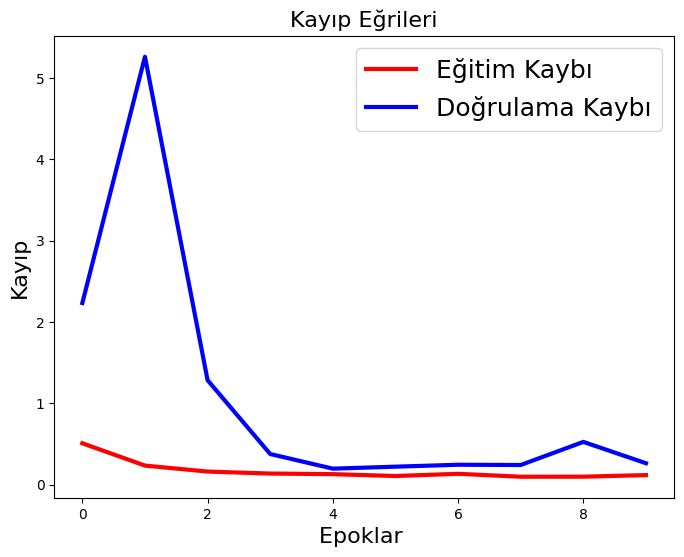

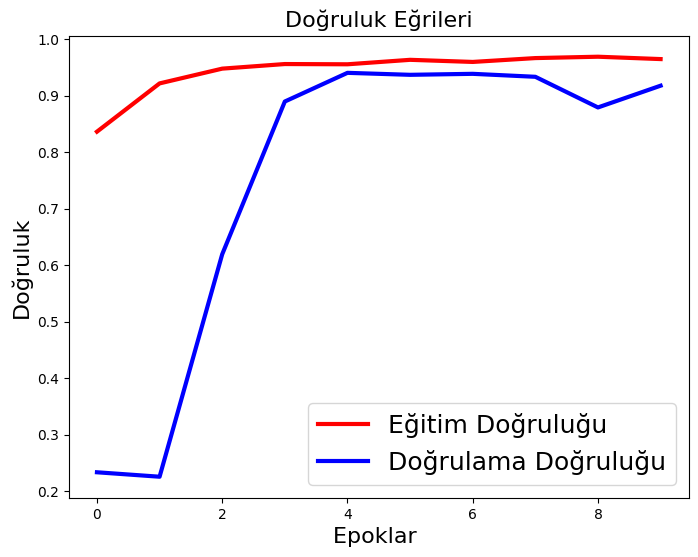

In [26]:
# Kayıp Eğrilerini Çiz
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Eğitim Kaybı', 'Doğrulama Kaybı'],fontsize=18)
plt.xlabel('Epoklar ',fontsize=16)
plt.ylabel('Kayıp',fontsize=16)
plt.title('Kayıp Eğrileri',fontsize=16)
plt.show()

# Doğruluk Eğrilerini Çiz
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Eğitim Doğruluğu', 'Doğrulama Doğruluğu'],fontsize=18)
plt.xlabel('Epoklar ',fontsize=16)
plt.ylabel('Doğruluk',fontsize=16)
plt.title('Doğruluk Eğrileri',fontsize=16)  
plt.show()

# Adım 9: Modelin Değerlendirilmesi

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       300
           1       0.98      0.91      0.94       306
           2       0.88      1.00      0.94       405
           3       0.98      0.94      0.96       300

    accuracy                           0.95      1311
   macro avg       0.96      0.94      0.95      1311
weighted avg       0.95      0.95      0.95      1311



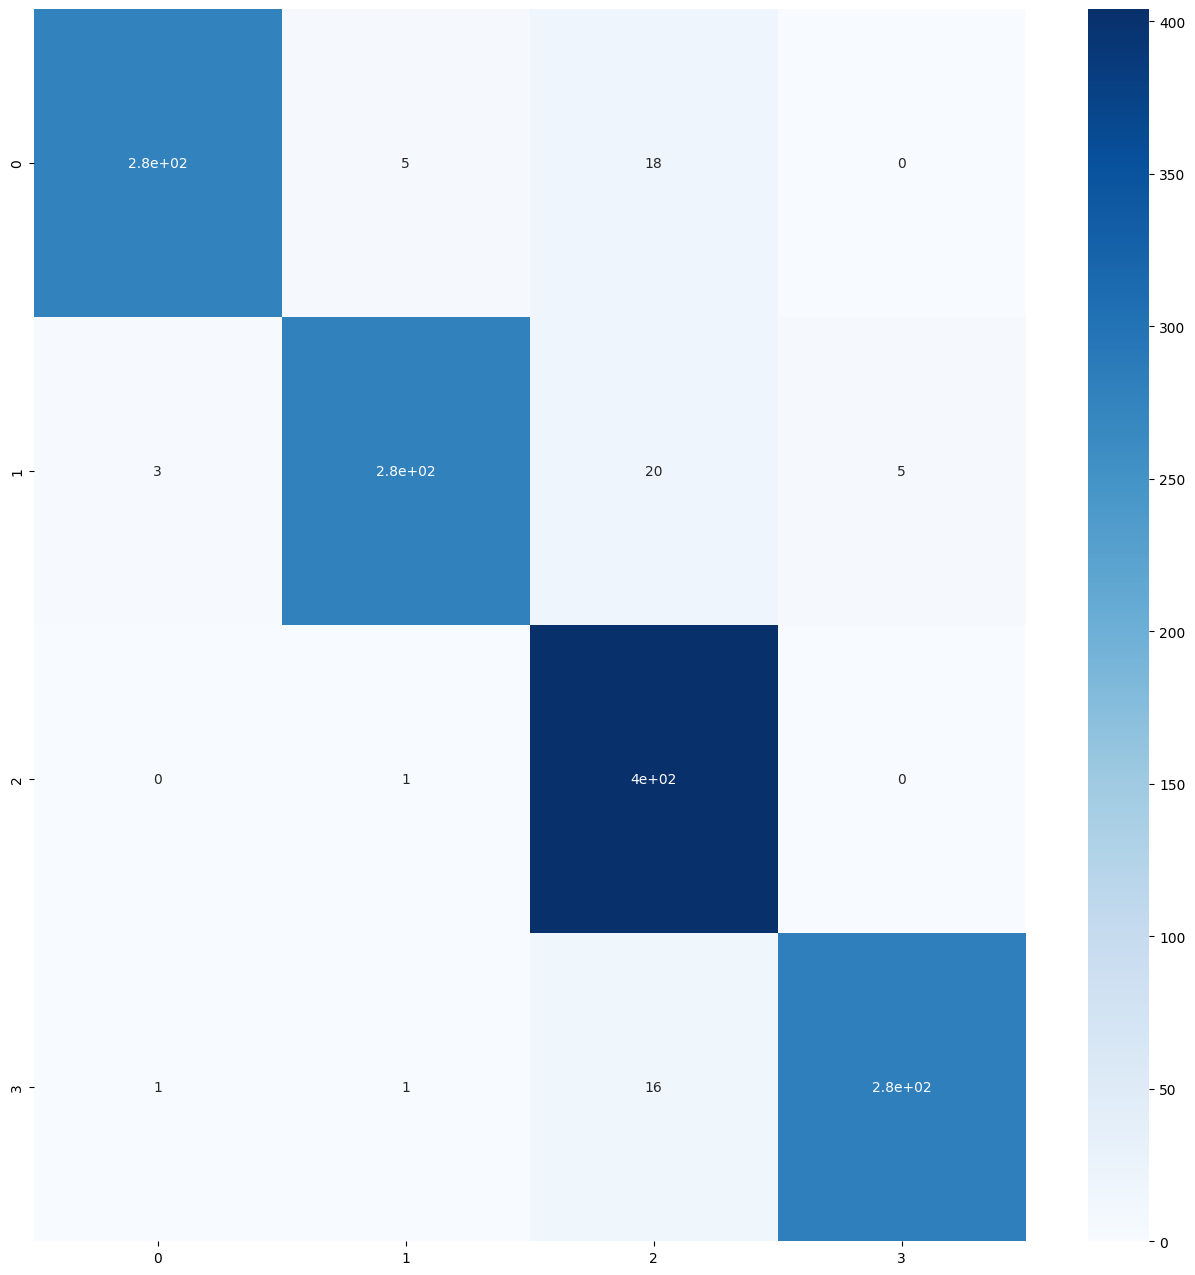

In [27]:
def predict_in_batches(model, data, batch_size=BATCH_SIZE):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_pred = model.predict(batch, verbose=0)
        predictions.extend(batch_pred)
    return np.array(predictions)

predicted_probs = predict_in_batches(model, x_test)
predicted_classes = np.argmax(predicted_probs, axis=1)

confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

<h3> Doğruluk </h3>

In [28]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 1s 28ms/step - loss: 0.1670 - accuracy: 0.9466
